# How to Develop Naive Models for Multi-step Energy Usage Forecasting   

In [1]:
# load and clean-up the power usage dataset
from numpy import nan
from numpy import isnan
from pandas import read_csv

In [2]:
# fill missing values with a value at the same time one day ago
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]

In [3]:
# load all data
dataset = read_csv('../Data/household_power_consumption/household_power_consumption.txt', sep=';', header=0, low_memory=False,
infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
# mark all missing values
dataset.replace('?', nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')
# fill missing
fill_missing(dataset.values)
# add a column for for the remainder of sub metering
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] +
values[:,6])
# save updated dataset
dataset.to_csv('../Data/household_power_consumption/household_power_consumption.csv')

/var/folders/z0/vn8ghqnn2sx5n3jbqtns9msr0000gq/T/ipykernel_5563/803618445.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('../Data/household_power_consumption/household_power_consumption.txt', sep=';', header=0, low_memory=False,
/var/folders/z0/vn8ghqnn2sx5n3jbqtns9msr0000gq/T/ipykernel_5563/803618445.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dataset = read_csv('../Data/household_power_consumption/household_power_consumption.txt', sep=';', header=0, low_memory=False,


In [4]:
# resample minute data to total for each day for the power usage dataset
from pandas import read_csv
# load the new file
dataset = read_csv('../Data/household_power_consumption/household_power_consumption.csv', header=0, infer_datetime_format=True,
parse_dates=['datetime'], index_col=['datetime'])
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())
# save
daily_data.to_csv('../Data/household_power_consumption/household_power_consumption_days.csv')

/var/folders/z0/vn8ghqnn2sx5n3jbqtns9msr0000gq/T/ipykernel_5563/2714633189.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('../Data/household_power_consumption/household_power_consumption.csv', header=0, infer_datetime_format=True,


(1442, 8)
            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16            5180.8             0.0           546.0          4926.0   
2006-12-17           14398.6          2033.0          4187.0         13341.0   
2006-12-18            9247.2          1063.0          2621.0         14018.0   
2006-12-19            7094.0           839.0          7602.0          6197.0   
2006-12-20            9313

In [5]:
# naive forecast strategies for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [6]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

In [7]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [8]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [9]:
# evaluate a single model
def evaluate_model(model_func, train, test):
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = model_func(history)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    predictions = array(predictions)
    # evaluate predictions days for each week
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [10]:
# daily persistence model
def daily_persistence(history):
    # get the data for the prior week
    last_week = history[-1]
    # get the total active power for the last day
    value = last_week[-1, 0]
    # prepare 7 day forecast
    forecast = [value for _ in range(7)]
    return forecast

In [11]:
# weekly persistence model
def weekly_persistence(history):
    # get the data for the prior week
    last_week = history[-1]
    return last_week[:, 0]

In [12]:
# week one year ago persistence model
def week_one_year_ago_persistence(history):
    # get the data for the prior week
    last_week = history[-52]
    return last_week[:, 0]

/var/folders/z0/vn8ghqnn2sx5n3jbqtns9msr0000gq/T/ipykernel_5563/115449079.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('../Data/household_power_consumption/household_power_consumption_days.csv', header=0,


daily: [638.933] 467.4, 642.0, 607.9, 706.1, 658.6, 629.6, 727.2
weekly: [605.523] 704.6, 611.7, 496.3, 647.0, 550.1, 446.9, 727.2
week-oya: [543.820] 657.5, 490.2, 430.0, 565.0, 477.0, 357.1, 733.8


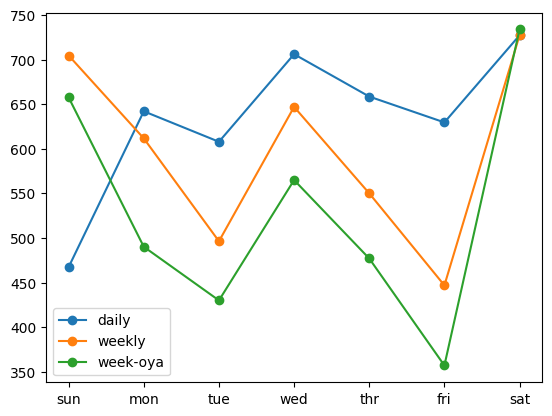

In [13]:
# load the new file
dataset = read_csv('../Data/household_power_consumption/household_power_consumption_days.csv', header=0,
    infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# define the names and functions for the models we wish to evaluate
models = dict()
models['daily'] = daily_persistence
models['weekly'] = weekly_persistence
models['week-oya'] = week_one_year_ago_persistence
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, func in models.items():
    # evaluate and get scores
    score, scores = evaluate_model(func, train, test)
    # summarize scores
    summarize_scores(name, score, scores)
    # plot scores
    pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()